# Resampling Hypothesis Tests for K Samples

In statistical hypothesis testing, a k-sample test is performed on the data of k-random samples. The purpose is to determine whether the population difference is statistically significant.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

from statsmodels.distributions.empirical_distribution import ECDF

## Bootstrap Method for k Independent Samples

The bootstrap method idea is simple: "If there is no difference between k treatments, a particular score is just as likely to end up in any group."

Let us generate some data.

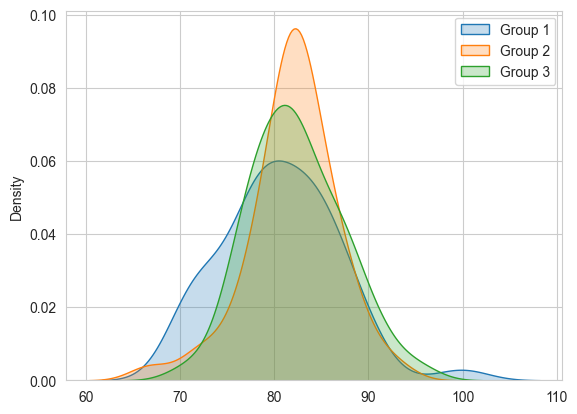

In [2]:
# Set the random number generator to a fixed sequence.
np.random.seed(50) 
g1_grades = np.random.normal(80, 6, size=50)
g2_grades = np.random.normal(82, 4, size=48)
g3_grades = np.random.normal(83, 5, size=52)

sns.kdeplot(g1_grades, fill = True, label="Group 1")
sns.kdeplot(g2_grades, fill = True, label="Group 2")
sns.kdeplot(g3_grades, fill = True, label="Group 3")
plt.legend();

In [3]:
print('Group 1 mean = %.2f' % g1_grades.mean())
print('Group 2 mean = %.2f' % g2_grades.mean())
print('Group 3 mean = %.2f' % g3_grades.mean())

Group 1 mean = 80.56
Group 2 mean = 81.92
Group 3 mean = 82.27


Let us transform the original samples into others that share their means.

In [4]:
# Getting the overall mean of the three independent samples
overall_mean_grades = np.concatenate((g1_grades, g2_grades, g3_grades)).mean()
print('Mean of combined sample = %.2f' % overall_mean_grades)

Mean of combined sample = 81.59


In [5]:
# Creating the new variables classC_shifted and classD_shifted that share the mean
g1_grades_shifted = g1_grades - g1_grades.mean() + overall_mean_grades
g2_grades_shifted = g2_grades - g2_grades.mean() + overall_mean_grades
g3_grades_shifted = g3_grades - g3_grades.mean() + overall_mean_grades

print('Mean of shifted g1_grades = %.2f' % g1_grades_shifted.mean())
print('Mean of shifted g2_grades = %.2f' % g2_grades_shifted.mean())
print('Mean of shifted g3_grades = %.2f' % g3_grades_shifted.mean())

Mean of shifted g1_grades = 81.59
Mean of shifted g2_grades = 81.59
Mean of shifted g3_grades = 81.59


`generate_samples` is the function for generating samples WITH replacement.

In [6]:
def generate_samples(sample_data, num_samples=10000):
    '''
    It generates num_samples samples using sample_data with the bootstrap method 
    and returns a DataFrame where each column is a sample.    
    '''
    sample_size = len(sample_data)
    col = ['S'+str(k) for k in range(num_samples)]
    samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
    df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
    return(df)  

In [7]:
df_1 = generate_samples(g1_grades_shifted, num_samples=10000)
df_2 = generate_samples(g1_grades_shifted, num_samples=10000)
df_3 = generate_samples(g1_grades_shifted, num_samples=10000)

df_1.head()

,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,78.664543,80.129679,85.484991,85.484991,78.875128,...,79.340707,82.741095,87.449885,71.030165,74.021142
1,79.140016,79.825781,71.030165,78.167886,71.666166,...,81.771476,72.240796,78.875128,82.741095,79.714310
2,76.345463,71.991143,78.554872,83.282803,85.549409,...,78.875128,79.340707,82.741095,76.345463,86.201441
3,80.129679,80.063988,78.875128,89.058731,83.299445,...,81.786304,89.499955,85.486507,71.030165,76.345463
4,73.334523,71.030165,85.170119,74.021142,85.486507,...,81.916973,86.954901,79.140016,91.293722,87.599536


We will use the following statistic: 
- square root root of the weighted sum of squared deviations between each mean and the overall mean

In [8]:
# Computing the statistic
n1 = len(g1_grades)
n2 = len(g2_grades)
n3 = len(g3_grades)
tot = n1 + n2 + n3

test_stat_bootI = np.sqrt((n1/tot) * (g1_grades.mean() - overall_mean_grades)**2 + 
                          (n2/tot) * (g2_grades.mean() - overall_mean_grades)**2 + 
                          (n3/tot) * (g3_grades.mean() - overall_mean_grades)**2)
print('Test statistic = %.2f' % test_stat_bootI)                  

Test statistic = 0.74


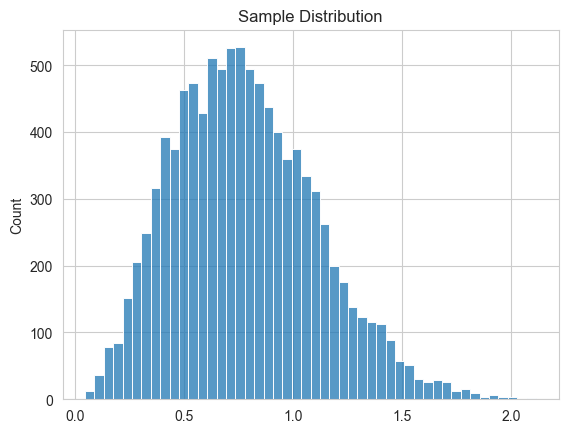

In [9]:
# Computing and plotting the sample distribution of the statistic
sample_distribution_bootI = np.sqrt((n1/tot) * (df_1.mean() - overall_mean_grades)**2 + 
                                    (n2/tot) * (df_2.mean() - overall_mean_grades)**2 + 
                                    (n3/tot) * (df_3.mean() - overall_mean_grades)**2)  
sns.histplot(x=sample_distribution_bootI).set(title='Sample Distribution');      

In [10]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value.
    sample_distribution:    the sample distribution
    obs_value:              the observed value     
    alternative:            'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2*min(ecdf(obs_value), 1 - ecdf(obs_value))        
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [11]:
def graph_hyp_test(sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
    '''
    It computes and graph the two-samples hypothesis test.
    sample_value:           observed value calculated from the sample
    sample_distribution:    sample distribution calculated from the sample
    alpha:                  significance level
    alternative:            'two-sided', 'smaller', and 'larger'
    '''
    print('--- Hypothesis Test ---')
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='skyblue', fill=True).set_title('Sample Distribution')  
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)       
    # get the p-value
    p_val = get_p_value(sample_distribution, sample_value, alternative)
    # plotting the two critical regions
    if alternative=='two-sided':        
        cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)         # left critical value    
        cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)     # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    # plotting the left critical region
    elif alternative=='smaller':        
        cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)             # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the right critical region
    else:                               
        cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)         # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # printing the statistic and the p-value    
    print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

--- Hypothesis Test ---
Observed Value = 0.74	p-value = 0.9764


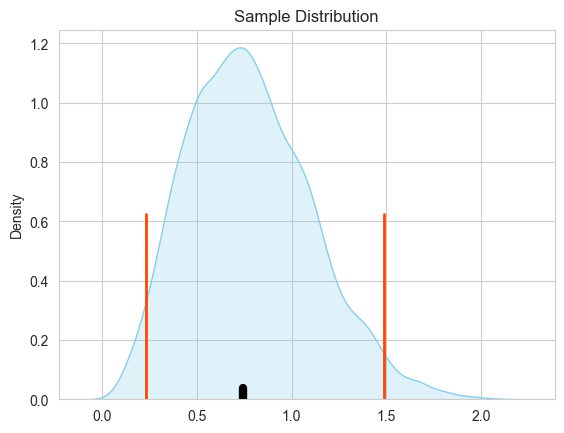

In [12]:
graph_hyp_test(test_stat_bootI, sample_distribution_bootI)

In [13]:
# Creating another variable with g4_grades
g4_grades = np.random.normal(60, 5, size=44)

In [14]:
overall_mean_grades4 = np.concatenate((g1_grades, g2_grades, g3_grades, g4_grades)).mean()

g4_grades_shifted = g4_grades - g4_grades.mean() + overall_mean_grades4

df_4 = generate_samples(g4_grades_shifted, num_samples=10000)

In [15]:
# Computing the statistic
n4 = len(g4_grades)
tot4 = n1 + n2 + n3 + n4
test_stat_bootI4 = np.sqrt((n1/tot4) * (g1_grades.mean() - overall_mean_grades4)**2 + 
                           (n2/tot4) * (g2_grades.mean() - overall_mean_grades4)**2 + 
                           (n3/tot4) * (g3_grades.mean() - overall_mean_grades4)**2 +
                           (n4/tot4) * (g4_grades.mean() - overall_mean_grades4)**2)
print('Test statistic = %.2f' % test_stat_bootI4)   

Test statistic = 9.25


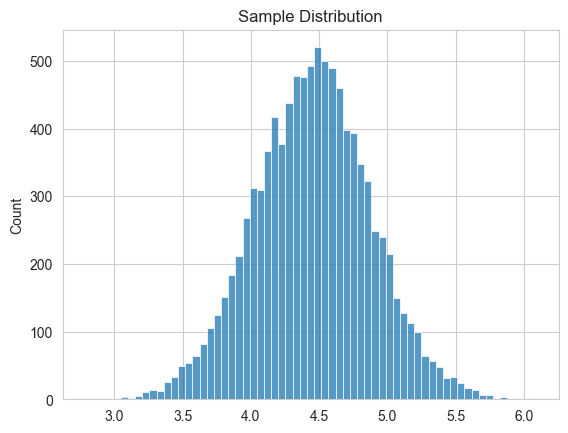

In [16]:
# Computing and plotting the sample distribution of the statistic
sample_distribution_bootI4 = np.sqrt((n1/tot4) * (df_1.mean() - overall_mean_grades4)**2 +
                                     (n2/tot4) * (df_2.mean() - overall_mean_grades4)**2 +
                                     (n3/tot4) * (df_3.mean() - overall_mean_grades4)**2 + 
                                     (n4/tot4) * (df_4.mean() - overall_mean_grades4)**2)
sns.histplot(x=sample_distribution_bootI4).set(title='Sample Distribution');      

--- Hypothesis Test ---
Observed Value = 9.25	p-value = 0.0000


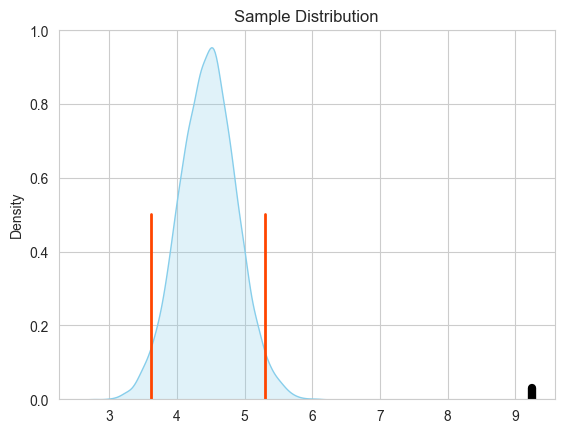

In [17]:
graph_hyp_test(test_stat_bootI4, sample_distribution_bootI4)

## Bootstrap method for k-related samples

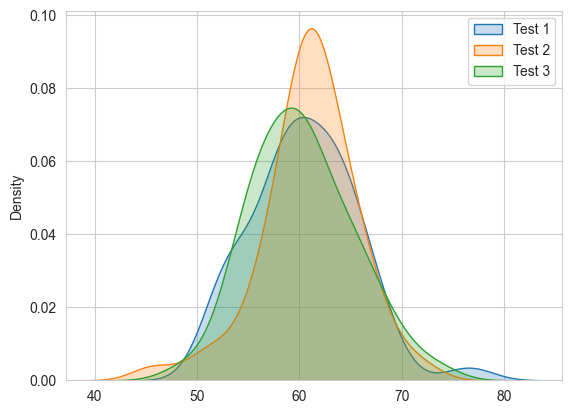

In [18]:
# Generating data
np.random.seed(50) 
test1 = np.random.normal(60, 5, size = 50)
test2 = np.random.normal(61, 4, size = 50)
test3 = np.random.normal(61, 5, size = 50)

# Plotting the data
sns.kdeplot(test1, fill = True, label = "Test 1")
sns.kdeplot(test2, fill = True, label = "Test 2")
sns.kdeplot(test3, fill = True, label = "Test 3")
plt.legend();

We will use the mean of the absolute value of the differences of all pairs of samples as statistic.

In [19]:
# Computing the statistic
test_stat_bootR = (np.abs(test1.mean() - test2.mean()) + 
                   np.abs(test1.mean() - test3.mean()) + 
                   np.abs(test2.mean() - test3.mean())) / 3
print('Test statistic = %.4f' % test_stat_bootR)    

Test statistic = 0.4929


Generating samples for k-related samples is not that easy. It is necessary to maintain the bond among the observations.

We will use "block resampling." The block resampling procedure respects the observation pairing of blocks of related observations.

In [20]:
# Generating samples with index
index = np.arange(0, len(test1))
print(index.min(), index.max())
df_t = generate_samples(index, num_samples=10000)
print(df_t.shape)
df_t.head()

0 49
(50, 10000)


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,20,28,19,19,46,...,26,25,7,44,49
1,36,40,44,5,0,...,18,3,46,25,45
2,6,43,22,39,34,...,46,26,25,6,11
3,28,23,46,31,47,...,10,4,41,44,6
4,8,44,29,49,41,...,21,17,36,27,30


In [21]:
df_t1 = pd.DataFrame(test1[df_t.values], columns=df_t.columns)
df_t2 = pd.DataFrame(test2[df_t.values], columns=df_t.columns)
df_t3 = pd.DataFrame(test3[df_t.values], columns=df_t.columns)

print(df_t1.shape)
df_t1.head()

(50, 10000)


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,58.030221,59.251167,63.713927,63.713927,58.205708,...,58.593690,61.427347,65.351339,51.668239,54.160720
1,58.426448,58.997918,51.668239,57.616339,52.198239,...,60.619331,52.677098,58.205708,61.427347,58.905026
2,56.097654,52.469054,57.938828,61.878770,63.767608,...,58.205708,58.593690,61.427347,56.097654,64.310969
3,59.251167,59.196425,58.205708,66.692044,61.892638,...,60.631688,67.059731,63.715190,51.668239,56.097654
4,53.588537,51.668239,63.451534,54.160720,63.715190,...,60.740579,64.938852,58.426448,68.554537,65.476048


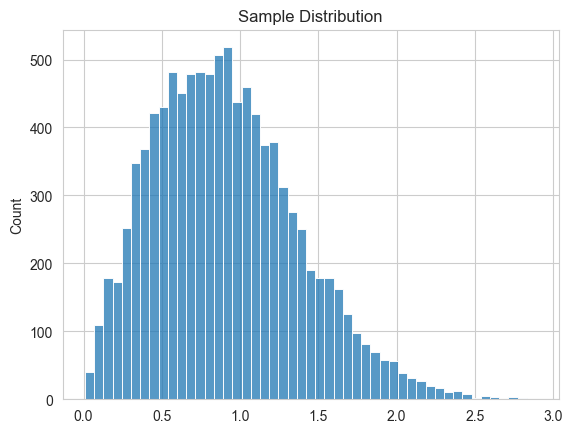

In [35]:
# Computing the sample distribution of the statistic
sample_distribution_bootR = (np.abs(df_t1.mean() - df_t2.mean()).values + 
                             np.abs(df_t1.mean() - df_t3.mean()).values + 
                             np.abs(df_t2.mean() - df_t3.mean()).values) / 3

sns.histplot(x=sample_distribution_bootR).set(title='Sample Distribution');

In [22]:
# ????????????????????????
# Shifting the data
overall_mean = np.concatenate((test1, test2, test3)).mean()

df_t1_shifted = df_t1 - df_t1.mean() + overall_mean
df_t2_shifted = df_t2 - df_t2.mean() + overall_mean
df_t3_shifted = df_t3 - df_t3.mean() + overall_mean

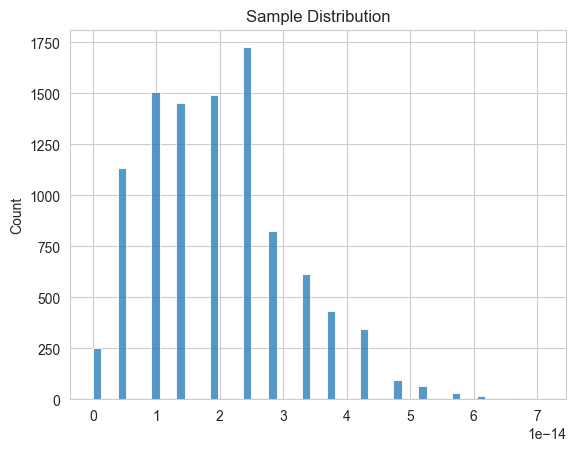

In [27]:
# ????????????????????????
# Computing the sample distribution of the statistic
sample_distribution_bootR = (np.abs(df_t1_shifted.mean() - df_t2_shifted.mean()).values + 
                             np.abs(df_t1_shifted.mean() - df_t3_shifted.mean()).values + 
                             np.abs(df_t2_shifted.mean() - df_t3_shifted.mean()).values) / 3

sns.histplot(x=sample_distribution_bootR).set(title='Sample Distribution');

In [36]:
print(sample_distribution_bootR.min(), sample_distribution_bootR.max())

0.010007533144265798 2.890680539723571


--- Hypothesis Test ---
Observed Value = 0.49	p-value = 0.3962


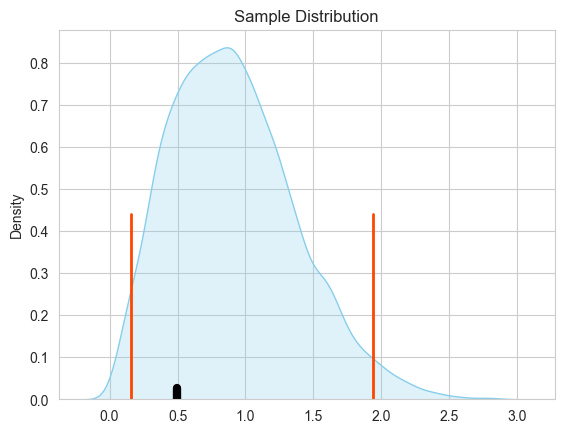

In [37]:
graph_hyp_test(test_stat_bootR, sample_distribution_bootR)

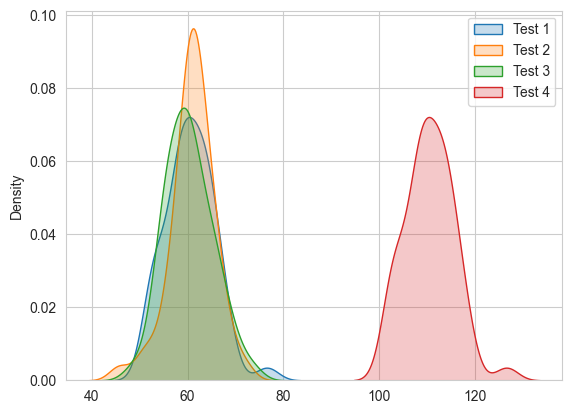

In [38]:
# Let's generate more data
np.random.seed(50) 
test4 = np.random.normal(110, 5, size = 50)

sns.kdeplot(test1, fill = True, label = "Test 1")
sns.kdeplot(test2, fill = True, label = "Test 2")
sns.kdeplot(test3, fill = True, label = "Test 3")
sns.kdeplot(test4, fill = True, label = "Test 4")
plt.legend();

In [39]:
# Computing the statistic
test_stat_bootR4 = (np.abs(test1.mean() - test2.mean()) + 
                    np.abs(test1.mean() - test3.mean()) + 
                    np.abs(test1.mean() - test4.mean()) +
                    np.abs(test2.mean() - test3.mean()) +
                    np.abs(test2.mean() - test4.mean()) +
                    np.abs(test3.mean() - test4.mean())) / 6                           
print('Test statistic = %.2f' % test_stat_bootR4)    

Test statistic = 25.21


In [40]:
# Generating samples
df_t4 = pd.DataFrame(test4[df_t.values], columns=df_t.columns)
print(df_t4.shape)
df_t4.head()

(50, 10000)


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,108.030221,109.251167,113.713927,113.713927,108.205708,...,108.593690,111.427347,115.351339,101.668239,104.160720
1,108.426448,108.997918,101.668239,107.616339,102.198239,...,110.619331,102.677098,108.205708,111.427347,108.905026
2,106.097654,102.469054,107.938828,111.878770,113.767608,...,108.205708,108.593690,111.427347,106.097654,114.310969
3,109.251167,109.196425,108.205708,116.692044,111.892638,...,110.631688,117.059731,113.715190,101.668239,106.097654
4,103.588537,101.668239,113.451534,104.160720,113.715190,...,110.740579,114.938852,108.426448,118.554537,115.476048


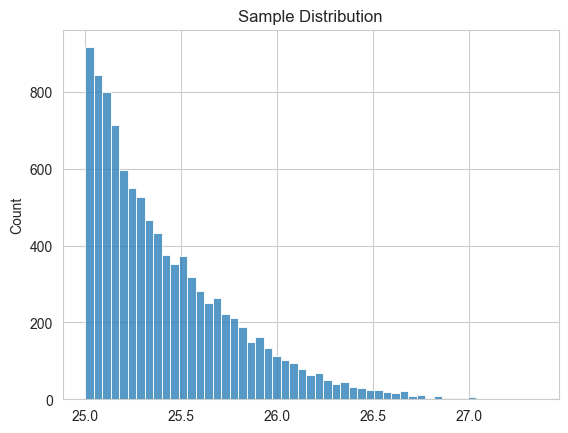

In [41]:
# Computing the sample distribution of the statistic
sample_distribution_bootR4 = (np.abs(df_t1.mean() - df_t2.mean()).values + 
                              np.abs(df_t1.mean() - df_t3.mean()).values + 
                              np.abs(df_t1.mean() - df_t4.mean()).values + 
                              np.abs(df_t2.mean() - df_t3.mean()).values + 
                              np.abs(df_t2.mean() - df_t4.mean()).values + 
                              np.abs(df_t3.mean() - df_t4.mean()).values) / 6
sns.histplot(x=sample_distribution_bootR4).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 25.21	p-value = 0.7410


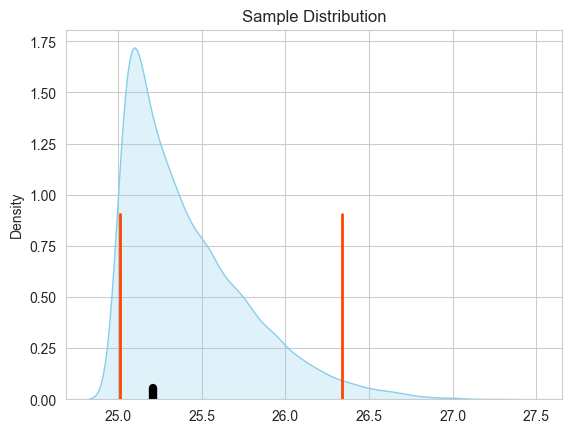

In [42]:
graph_hyp_test(test_stat_bootR4, sample_distribution_bootR4)

## Permutation Method for k Independent Samples

Let us use a permutation test to determine whether the k means are equal or not.

The method is very similar to the bootstrap, but a fundamental difference is that the bootstrap resamples with replacement and the permutation test does not. 

In [29]:
# Computing the statistic
test_stat_permI = np.sqrt((n1/tot) * (g1_grades.mean() - overall_mean_grades)**2 + 
                          (n2/tot) * (g2_grades.mean() - overall_mean_grades)**2 + 
                          (n3/tot) * (g3_grades.mean() - overall_mean_grades)**2)
print('Test statistic = %.2f' % test_stat_permI)   

Test statistic = 0.74


In [30]:
def shuffle_k_samples(*samples, num_samples=10000):
    '''
    It returns k DataFrames, where each column is a permutation (sampling without replacement)
    '''    
    pool = np.concatenate([*samples])      
    # Creating a DataFrame with one column
    df = pd.DataFrame(pool)
    # Replicating the column num_samples times
    df = (pd.concat([df]*num_samples, axis=1, ignore_index=True)).rename(lambda c: 'S'+str(c), axis=1)    
    # Shuffling the data
    df = df.apply(np.random.permutation)    
    # Creating k new DataFrames
    df_list = []
    for i in range(len(samples)):
        df_list.append(df[df.index < len(samples[i])])
        df = df[df.index >= len(samples[i])].reset_index(drop=True)            
    return df_list

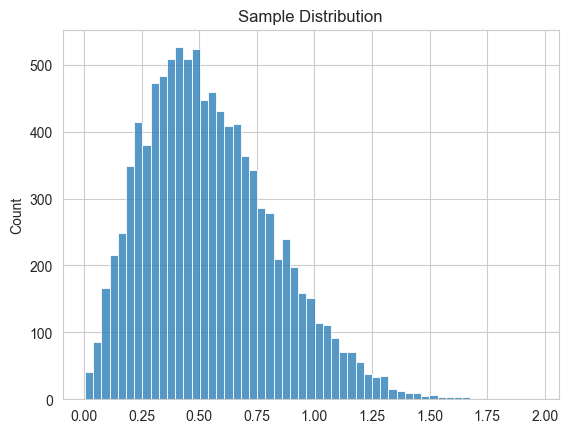

In [31]:
# Computing and plotting the sample distribution of the statistic
df_p1, df_p2, df_p3 = shuffle_k_samples(g1_grades, g2_grades, g3_grades)
sample_distribution_permI = np.sqrt((n1/tot) * (df_p1.mean() - overall_mean_grades)**2 +
                                   (n2/tot) * (df_p2.mean() - overall_mean_grades)**2 +
                                   (n3/tot) * (df_p3.mean() - overall_mean_grades)**2)    
sns.histplot(x=sample_distribution_permI).set(title='Sample Distribution');   

--- Hypothesis Test ---
Observed Value = 0.74	p-value = 0.4628


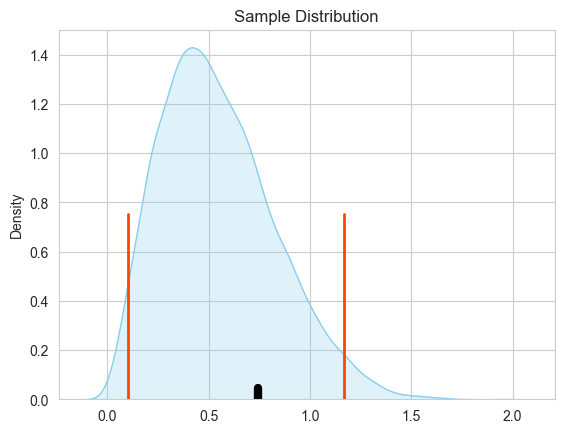

In [32]:
graph_hyp_test(test_stat_permI, sample_distribution_permI)

Including g4_grades in the analysis.

In [33]:
# Computing the statistic
test_stat_permI4 = np.sqrt((n1/tot4) * (g1_grades.mean() - overall_mean_grades4)**2 + 
                           (n2/tot4) * (g2_grades.mean() - overall_mean_grades4)**2 + 
                           (n3/tot4) * (g3_grades.mean() - overall_mean_grades4)**2 +
                           (n4/tot4) * (g4_grades.mean() - overall_mean_grades4)**2
                           )
print('Test statistic = %.2f' % test_stat_permI4)  

Test statistic = 9.25


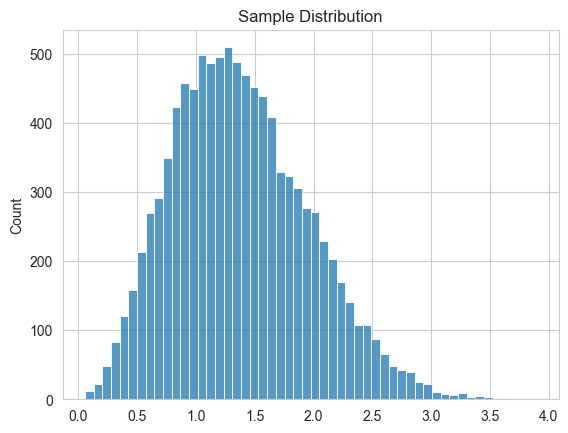

In [34]:
# Computing and plotting the sample distribution of the statistic
df_p1, df_p2, df_p3, df_p4 = shuffle_k_samples(g1_grades, g2_grades, g3_grades, g4_grades)
sample_distribution_permI4 = np.sqrt((n1/tot) * (df_p1.mean() - overall_mean_grades4)**2 +
                                     (n2/tot) * (df_p2.mean() - overall_mean_grades4)**2 +
                                     (n3/tot) * (df_p3.mean() - overall_mean_grades4)**2 +
                                     (n4/tot) * (df_p4.mean() - overall_mean_grades4)**2)    
sns.histplot(x=sample_distribution_permI4).set(title='Sample Distribution');   

--- Hypothesis Test ---
Observed Value = 9.25	p-value = 0.0000


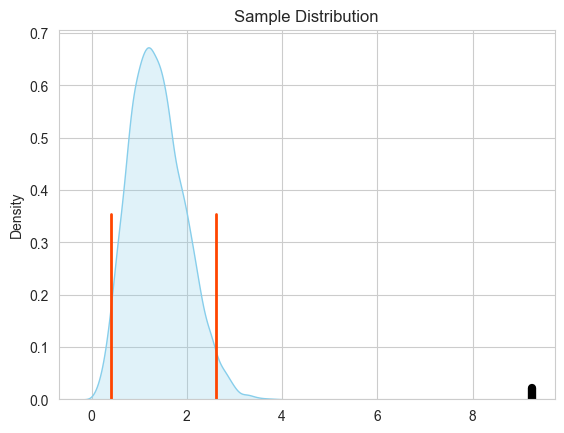

In [35]:
graph_hyp_test(test_stat_permI4, sample_distribution_permI4)

##  Permutation Test for k Related Samples

In [36]:
# Computing the statistic
test_stat_permR = (np.abs(test1.mean() - test2.mean()) + 
                   np.abs(test1.mean() - test3.mean()) + 
                   np.abs(test2.mean() - test3.mean())) / 3
print('Test statistic = %.2f' % test_stat_permR)   

Test statistic = 0.49


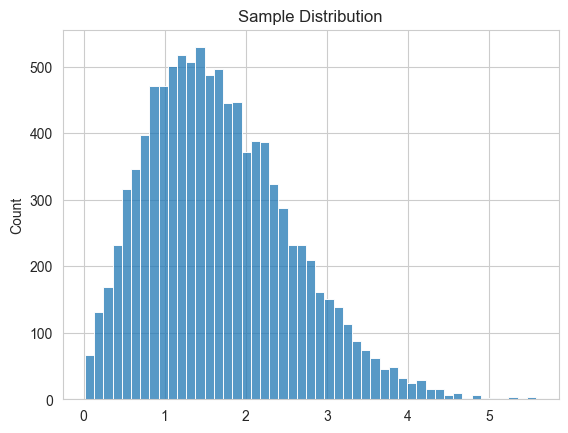

In [37]:
# Computing the sample distribution of the statistic
sample_distribution_permR = (np.abs(df_p1.mean() - df_p2.mean()).values + 
                             np.abs(df_p1.mean() - df_p3.mean()).values + 
                             np.abs(df_p2.mean() - df_p3.mean()).values) / 3
sns.histplot(x=sample_distribution_permR).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 0.49	p-value = 0.1292


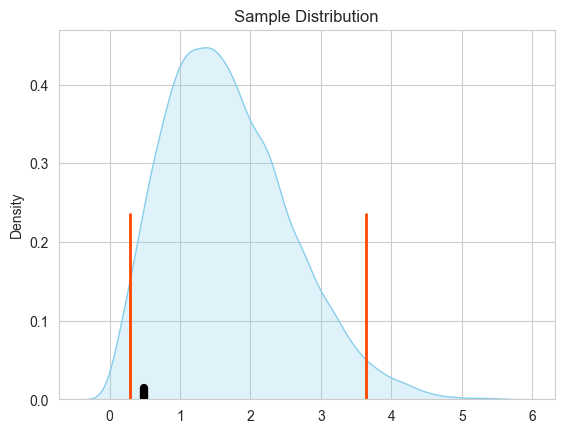

In [38]:
graph_hyp_test(test_stat_permR, sample_distribution_permR)

Including test4 in the analysis

In [39]:
# Computing the statistic
test_stat_permR4 = (np.abs(test1.mean() - test2.mean()) + 
                    np.abs(test1.mean() - test3.mean()) + 
                    np.abs(test1.mean() - test4.mean()) +
                    np.abs(test2.mean() - test3.mean()) +
                    np.abs(test2.mean() - test4.mean()) +
                    np.abs(test3.mean() - test4.mean())) / 6                           
print('Test statistic = %.2f' % test_stat_permR4)  

Test statistic = 55.07


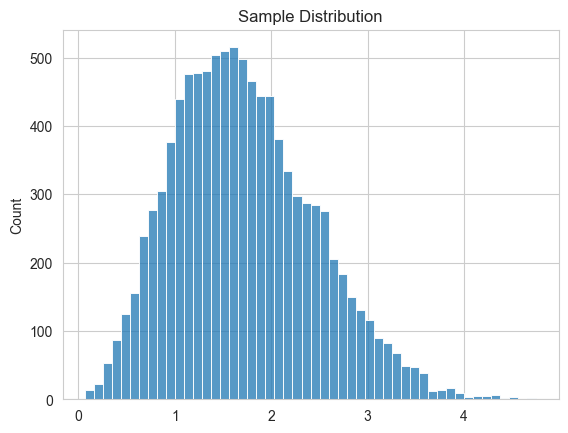

In [40]:
# Computing the sample distribution of the statistic
sample_distribution_permR4 = (np.abs(df_p1.mean() - df_p2.mean()).values + 
                              np.abs(df_p1.mean() - df_p3.mean()).values + 
                              np.abs(df_p1.mean() - df_p4.mean()).values + 
                              np.abs(df_p2.mean() - df_p3.mean()).values + 
                              np.abs(df_p2.mean() - df_p4.mean()).values + 
                              np.abs(df_p3.mean() - df_p4.mean()).values) / 6
sns.histplot(x=sample_distribution_permR4).set(title='Sample Distribution');

--- Hypothesis Test ---
Observed Value = 55.07	p-value = 0.0000


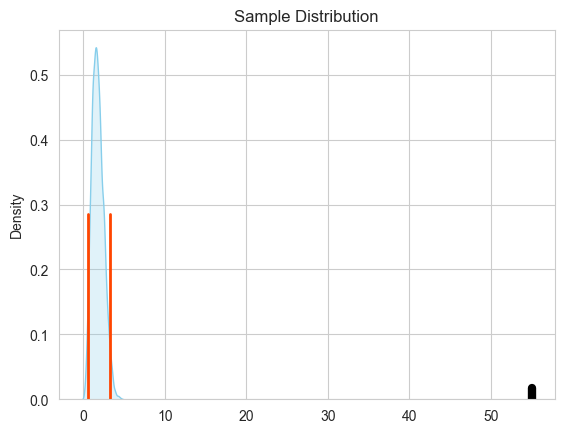

In [41]:
graph_hyp_test(test_stat_permR4, sample_distribution_permR4)

## References

- Dekking, F.M. et.al. (2005) A Modern Introduction to Probability and Statistics, USA: Springer